In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
from lmfit.models import Model

In [3]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_dincident,inc_dreported,inc_loctype,inc_specialty from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC' and inc_organisation='QA'"
df = pd.read_sql(query, sql_conn)
print(df)

     inc_dincident inc_dreported inc_loctype inc_specialty
0       2016-03-31    2016-03-31        WARD          RESP
1       2016-03-31    2016-04-01        WARD        GENMED
2       2016-04-01    2016-04-01          AE            ED
3       2016-03-25    2016-04-01        WARD        CARDIO
4       2016-04-02    2016-04-02        WARD         ORTHO
5       2016-04-01    2016-04-02        WARD         ACUTE
6       2016-04-01    2016-04-02        WARD         ACUTE
7       2016-04-02    2016-04-02        WARD         ORTHO
8       2016-04-02    2016-04-02        WARD        ACTSTK
9       2016-04-03    2016-04-03        PHAR         PHARM
10      2016-04-03    2016-04-03        WARD        GASTRO
11      2016-04-02    2016-04-04        WARD        GASTRO
12      2016-04-02    2016-04-04        WARD        GASTRO
13      2016-04-02    2016-04-04        WARD        GASTRO
14      2016-04-02    2016-04-04         OPD        OPHTHL
15      2016-04-02    2016-04-04        WARD        GENM

In [4]:
df_inc = df.copy()
df_inc = df_inc[df_inc.inc_dincident > '2016-03-31']
df_inc = df_inc[df_inc.inc_dincident < '2019-11-23']
df_inc['weekday'] = df_inc['inc_dincident'].dt.weekday
print(df)

     inc_dincident inc_dreported inc_loctype inc_specialty
0       2016-03-31    2016-03-31        WARD          RESP
1       2016-03-31    2016-04-01        WARD        GENMED
2       2016-04-01    2016-04-01          AE            ED
3       2016-03-25    2016-04-01        WARD        CARDIO
4       2016-04-02    2016-04-02        WARD         ORTHO
5       2016-04-01    2016-04-02        WARD         ACUTE
6       2016-04-01    2016-04-02        WARD         ACUTE
7       2016-04-02    2016-04-02        WARD         ORTHO
8       2016-04-02    2016-04-02        WARD        ACTSTK
9       2016-04-03    2016-04-03        PHAR         PHARM
10      2016-04-03    2016-04-03        WARD        GASTRO
11      2016-04-02    2016-04-04        WARD        GASTRO
12      2016-04-02    2016-04-04        WARD        GASTRO
13      2016-04-02    2016-04-04        WARD        GASTRO
14      2016-04-02    2016-04-04         OPD        OPHTHL
15      2016-04-02    2016-04-04        WARD        GENM

In [5]:
total_weeks = (max(df_inc.inc_dincident)-min(df_inc.inc_dincident)).days/7
print(total_weeks)

190.0


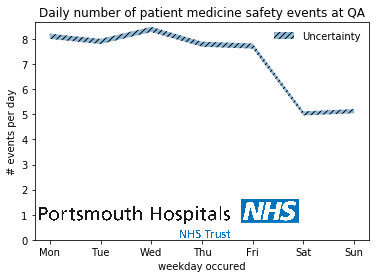

In [6]:
bins = [i-0.5 for i in range(8)]
data_x = [i for i in range(7)]
data_y_tot,_ = np.histogram(df_inc.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
plt.fill_between(data_x,data_y-data_y_err/2,y2=data_y+data_y_err/2,alpha=0.5,hatch="////",label='Uncertainty')
plt.legend(frameon=False)
plt.ylim(bottom=0)
ax = plt.gca()
locs, labels = plt.xticks()
plt.xticks(np.arange(7),labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('weekday occured');
plt.ylabel('# events per day')
plt.title('Daily number of patient medicine safety events at QA');
img = plt.imread("nhsportsmouth.png");
ax = plt.axes([0.125+0.01,-0.1, 0.6, 0.6], frameon=True)  # Change the numbers in this array to position your image [left, bottom, width, height])
ax.imshow(img);
ax.axis('off'); # get rid of the ticks and ticklabels

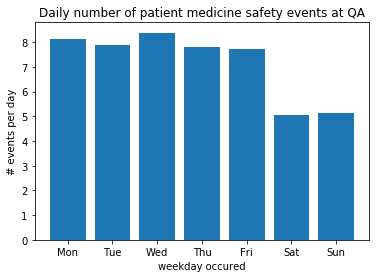

In [10]:
plt.bar(data_x,data_y)
plt.ylim(bottom=0)
ax = plt.gca()
locs, labels = plt.xticks()
plt.xticks(np.arange(7),labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('weekday occured');
plt.ylabel('# events per day')
plt.title('Daily number of patient medicine safety events at QA');

In [6]:
# data fit

def raised_backward_step(x, A, raised):
    return [A if xi<4.5 else raised for xi in x]

step_model = Model(raised_backward_step)
out = step_model.fit(data_y, x=data_x, weights=1/data_y_err, A=data_y[0], raised=data_y[-1])

In [14]:
# Import figure from bokeh.plotting
from bokeh.plotting import figure

# Import output_file and show from bokeh.io
from bokeh.io import show, output_notebook

from bokeh.models import ColumnDataSource, Band, Legend, LegendItem, Span, HoverTool


groups= ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
counts = data_y
error = data_y_err
upper = [x+e for x,e in zip(counts, error) ]
lower = [x-e for x,e in zip(counts, error) ]

source = ColumnDataSource(data=dict(groups=groups, counts=counts, upper=upper, lower=lower))

p = figure(x_range=groups, plot_height=450, title="Daily medicine patient safety events at QA", y_range=(0,8.9),
          x_axis_label='Weekday',y_axis_label='events per day',
          tools='pan,box_zoom,wheel_zoom,save,reset,help')

r_fit = p.line(groups,out.best_fit,line_color='purple')

band = Band(base='groups', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black')
p.add_layout(band)

p.xgrid.grid_line_color = None

legend = Legend(items=[
    LegendItem(label="uncertainty", renderers=[p.vbar(x=0, top=0, width=0.9, color='yellow', line_width=1, line_color='black')]),
    LegendItem(label='fit χ²/Nᵈᶠ = '+str(round(out.redchi,1)), renderers=[r_fit]),
])
p.add_layout(legend)

vline = Span(location=5, dimension='height', line_color='red', line_width=3)
p.renderers.extend([vline])

output_notebook()

Loading BokehJS ...

In [8]:
show(p)

In [9]:
df_ICU = df[df['inc_loctype']=='ICU'].copy()
df_ICU['weekday'] = df_ICU['inc_dincident'].dt.weekday
data_y_tot,_ = np.histogram(df_ICU.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
out = step_model.fit(data_y, x=data_x, weights=1/data_y_err, A=data_y[0], raised=data_y[-1])
counts = data_y
error = data_y_err
upper = [x+e for x,e in zip(counts, error) ]
lower = [x-e for x,e in zip(counts, error) ]

source = ColumnDataSource(data=dict(groups=groups, counts=counts, upper=upper, lower=lower))

p = figure(x_range=groups, plot_height=450, title="Daily medicine patient safety events at QA", y_range=(0,1),
          x_axis_label='Weekday',y_axis_label='events per day',
          tools='pan,box_zoom,wheel_zoom,save,reset,help')

r_fit = p.line(groups,out.best_fit,line_color='purple')

band = Band(base='groups', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black')
p.add_layout(band)

p.xgrid.grid_line_color = None

legend = Legend(items=[
    LegendItem(label="uncertainty", renderers=[p.vbar(x=0, top=0, width=0.9, color='yellow', line_width=1, line_color='black')]),
    LegendItem(label='fit χ²/Nᵈᶠ = '+str(round(out.redchi,1)), renderers=[r_fit]),
])
p.add_layout(legend)

vline = Span(location=5, dimension='height', line_color='red', line_width=3)
p.renderers.extend([vline])

output_notebook()
show(p)

Loading BokehJS ...

In [10]:
df_nonICU = df[df['inc_loctype']!='ICU'].copy()
df_nonICU['weekday'] = df_nonICU['inc_dincident'].dt.weekday
data_y_tot,_ = np.histogram(df_nonICU.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
out = step_model.fit(data_y, x=data_x, weights=1/data_y_err, A=data_y[0], raised=data_y[-1])
counts = data_y
error = data_y_err
upper = [x+e for x,e in zip(counts, error) ]
lower = [x-e for x,e in zip(counts, error) ]

source = ColumnDataSource(data=dict(groups=groups, counts=counts, upper=upper, lower=lower))

p = figure(x_range=groups, plot_height=450, title="Daily medicine patient safety events at QA", y_range=(0,8.9),
          x_axis_label='Weekday',y_axis_label='events per day',
          tools='pan,box_zoom,wheel_zoom,save,reset,help')

r_fit = p.line(groups,out.best_fit,line_color='purple')

band = Band(base='groups', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black')
p.add_layout(band)

p.xgrid.grid_line_color = None

legend = Legend(items=[
    LegendItem(label="uncertainty", renderers=[p.vbar(x=0, top=0, width=0.9, color='yellow', line_width=1, line_color='black')]),
    LegendItem(label='fit χ²/Nᵈᶠ = '+str(round(out.redchi,1)), renderers=[r_fit]),
])
p.add_layout(legend)

vline = Span(location=5, dimension='height', line_color='red', line_width=3)
p.renderers.extend([vline])

output_notebook()
show(p)

Loading BokehJS ...

In [18]:
df_AMU = df[df['inc_specialty']=='ACUTE'].copy()
df_AMU['weekday'] = df_AMU['inc_dincident'].dt.weekday
data_y_tot,_ = np.histogram(df_AMU.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
out = step_model.fit(data_y, x=data_x, weights=1/data_y_err, A=data_y[0], raised=data_y[-1])
counts = data_y
error = data_y_err
upper = [x+e for x,e in zip(counts, error) ]
lower = [x-e for x,e in zip(counts, error) ]

source = ColumnDataSource(data=dict(groups=groups, counts=counts, upper=upper, lower=lower))

p = figure(x_range=groups, plot_height=450, title="Daily medicine patient safety events at QA", y_range=(0,2),
          x_axis_label='Weekday',y_axis_label='events per day',
          tools='pan,box_zoom,wheel_zoom,save,reset,help')

r_fit = p.line(groups,out.best_fit,line_color='purple')

band = Band(base='groups', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black')
p.add_layout(band)

p.xgrid.grid_line_color = None

legend = Legend(items=[
    LegendItem(label="uncertainty", renderers=[p.vbar(x=0, top=0, width=0.9, color='yellow', line_width=1, line_color='black')]),
    LegendItem(label='fit χ²/Nᵈᶠ = '+str(round(out.redchi,1)), renderers=[r_fit]),
])
p.add_layout(legend)

vline = Span(location=5, dimension='height', line_color='red', line_width=3)
p.renderers.extend([vline])

output_notebook()
show(p)

Loading BokehJS ...

In [22]:
df_nonAMU = df[df['inc_specialty']!='ACUTE'].copy()
df_nonAMU['weekday'] = df_nonAMU['inc_dincident'].dt.weekday
data_y_tot,_ = np.histogram(df_nonAMU.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
out = step_model.fit(data_y, x=data_x, weights=1/data_y_err, A=data_y[0], raised=data_y[-1])
counts = data_y
error = data_y_err
upper = [x+e for x,e in zip(counts, error) ]
lower = [x-e for x,e in zip(counts, error) ]

source = ColumnDataSource(data=dict(groups=groups, counts=counts, upper=upper, lower=lower))

p = figure(x_range=groups, plot_height=450, title="Daily medicine patient safety events at QA", y_range=(0,8),
          x_axis_label='Weekday',y_axis_label='events per day',
          tools='pan,box_zoom,wheel_zoom,save,reset,help')

r_fit = p.line(groups,out.best_fit,line_color='purple')

band = Band(base='groups', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black')
p.add_layout(band)

p.xgrid.grid_line_color = None

legend = Legend(items=[
    LegendItem(label="uncertainty", renderers=[p.vbar(x=0, top=0, width=0.9, color='yellow', line_width=1, line_color='black')]),
    LegendItem(label='fit χ²/Nᵈᶠ = '+str(round(out.redchi,1)), renderers=[r_fit]),
])
p.add_layout(legend)

vline = Span(location=5, dimension='height', line_color='red', line_width=3)
p.renderers.extend([vline])

output_notebook()
show(p)

Loading BokehJS ...

In [12]:
df_rep = df.copy()
df_rep = df_rep[df_rep.inc_dreported > '2016-03-31']
df_rep = df_rep[df_rep.inc_dreported < '2019-10-05']
df_rep['weekday'] = df_rep['inc_dincident'].dt.weekday

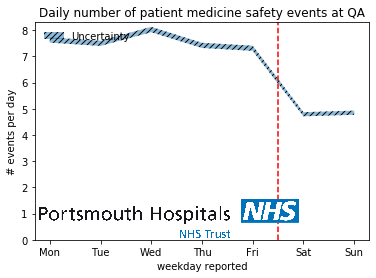

In [13]:
data_y_tot,_ = np.histogram(df_rep.weekday.values, bins=bins)
data_y = data_y_tot/total_weeks
data_y_err = np.sqrt(data_y_tot)/total_weeks
plt.fill_between(data_x,data_y-data_y_err/2,y2=data_y+data_y_err/2,alpha=0.5,hatch="////",label='Uncertainty')
plt.legend(frameon=False)
plt.ylim(bottom=0)
ax = plt.gca()
locs, labels = plt.xticks()
plt.xticks(np.arange(7),labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('weekday reported');
plt.ylabel('# events per day')
plt.title('Daily number of patient medicine safety events at QA');
ax.axvline(4.5,color='red',linestyle='--')
img = plt.imread("nhsportsmouth.png");
ax = plt.axes([0.125+0.01,-0.1, 0.6, 0.6], frameon=True)  # Change the numbers in this array to position your image [left, bottom, width, height])
ax.imshow(img);
ax.axis('off'); # get rid of the ticks and ticklabels